##### Copyright 2021 The TF-Agents Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

### Checkpointer and PolicySaver

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/agents/tutorials/10_checkpointer_policysaver_tutorial">
    <img src="https://www.tensorflow.org/images/tf_logo_32px.png" />
    View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/colab_logo_32px.png" />
    Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/agents/blob/master/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb">
    <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />
    View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/agents/docs/tutorials/10_checkpointer_policysaver_tutorial.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

## Introduction

`tf_agents.utils.common.Checkpointer` is a utility to save/load the training state, policy state, and replay_buffer state to/from a local storage.

`tf_agents.policies.policy_saver.PolicySaver` is a tool to save/load only the policy, and is lighter than `Checkpointer`. You can use `PolicySaver` to deploy the model as well without any knowledge of the code that created the policy.

In this tutorial, we will use DQN to train a model, then use `Checkpointer` and `PolicySaver` to show how we can store and load the states and model in an interactive way. Note that we will use TF2.0's new saved_model tooling and format for `PolicySaver`.


## Setup

 If you haven't installed the following dependencies, run:

In [2]:
#@test {"skip": true}
!sudo apt-get install -y xvfb ffmpeg
!pip install -q 'imageio==2.4.0'
!pip install -q 'xvfbwrapper==0.2.9'
!pip install -q tf-agents

The following packages were automatically installed and are no longer required:
  adwaita-icon-theme ca-certificates-java dconf-gsettings-backend
  dconf-service default-jre default-jre-headless dkms fonts-dejavu-extra
  freeglut3 freeglut3-dev g++-6 glib-networking glib-networking-common
  glib-networking-services gsettings-desktop-schemas gtk-update-icon-cache
  hicolor-icon-theme humanity-icon-theme java-common libaccinj64-9.1
  libatk-bridge2.0-0 libatk-wrapper-java libatk-wrapper-java-jni libatk1.0-0
  libatk1.0-data libatspi2.0-0 libavahi-client3 libavahi-common-data
  libavahi-common3 libcairo-gobject2 libcolord2 libcudart9.1 libcufft9.1
  libcufftw9.1 libcups2 libcurand9.1 libcusolver9.1 libcusparse9.1 libdconf1
  libdrm-dev libegl-mesa0 libegl1 libegl1-mesa libepoxy0 libgbm1 libgif7
  libgl1-mesa-dev libgles1 libgles2 libglu1-mesa libglu1-mesa-dev
  libglvnd-core-dev libglvnd-dev libgtk-3-0 libgtk-3-common libgtk2.0-0
  libgtk2.0-common libice-dev libjansson4 libjson-glib-1.0-

The following NEW packages will be installed:
  ffmpeg i965-va-driver libaacs0 libass9 libavc1394-0 libavcodec57
  libavdevice57 libavfilter6 libavformat57 libavresample3 libavutil55
  libbdplus0 libbluray2 libbs2b0 libcaca0 libcdio-cdda2 libcdio-paranoia2
  libcdio17 libchromaprint1 libcrystalhd3 libdc1394-22 libfftw3-double3
  libflite1 libgme0 libgsm1 libiec61883-0 libjack-jackd2-0 libllvm10
  libmp3lame0 libmpg123-0 libmysofa0 libnorm1 libnuma1 libopenal-data
  libopenal1 libopenjp2-7 libopenmpt0 libopus0 libpgm-5.2-0 libpostproc54
  libraw1394-11 librubberband2 libsamplerate0 libsdl2-2.0-0 libshine3
  libsnappy1v5 libsndio6.1 libsodium23 libsoxr0 libspeex1 libssh-gcrypt-4
  libswresample2 libswscale4 libtheora0 libtwolame0 libva-drm2 libva-x11-2
  libva2 libvorbisfile3 libvpx5 libwavpack1 libwebpmux3 libx264-152
  libx265-146 libxss1 libxvidcore4 libzmq5 libzvbi-common libzvbi0
  mesa-va-drivers va-driver-all xvfb
The following packages will be upgraded:
  libdrm-amdgpu1 libdrm-co

Get:1 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libxss1 amd64 1:1.2.2-1 [8582 B]
Get:2 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-common all 2.4.101-2~18.04.1 [5560 B]
Get:3 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-dev amd64 2.4.101-2~18.04.1 [126 kB]
Get:4 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-intel1 amd64 2.4.101-2~18.04.1 [60.0 kB]
Get:5 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-radeon1 amd64 2.4.101-2~18.04.1 [21.7 kB]
Get:6 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-nouveau2 amd64 2.4.101-2~18.04.1 [16.5 kB]
Get:7 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm-amdgpu1 amd64 2.4.101-2~18.04.1 [18.2 kB]
Get:8 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libdrm2 amd64 2.4.101-2~18.04.1 [32.3 kB]
2% [Wait

Get:9 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libnuma1 amd64 2.0.11-2.1ubuntu0.1 [22.0 kB]
3% [Waiting for headers]

3% [Waiting for headers]

Get:10 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva2 amd64 2.1.0-3 [47.6 kB]
3% [Waiting for headers]

Get:11 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva-drm2 amd64 2.1.0-3 [6880 B]
Get:12 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libva-x11-2 amd64 2.1.0-3 [11.5 kB]
Get:13 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavutil55 amd64 7:3.4.8-0ubuntu0.2 [190 kB]
4% [13 libavutil55 8042 B/190 kB 4%]

Get:14 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libcrystalhd3 amd64 1:0.0~git20110715.fdd2f19-12 [45.8 kB]
5% [Working]

Get:15 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libgsm1 amd64 1.0.13-4build1 [22.4 kB]
5% [Waiting for headers]

Get:16 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libmp3lame0 amd64 3.100-2 [136 kB]
Get:17 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libopenjp2-7 amd64 2.3.0-2build0.18.04.1 [145 kB]
6% [Waiting for headers]

Get:18 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libopus0 amd64 1.1.2-1ubuntu1 [159 kB]
6% [18 libopus0 16.5 kB/159 kB 10%]

6% [Waiting for headers]

Get:19 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libshine3 amd64 3.1.1-1 [22.9 kB]
Get:20 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsnappy1v5 amd64 1.1.7-1 [16.0 kB]
7% [Waiting for headers]

Get:21 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libspeex1 amd64 1.2~rc1.2-1ubuntu2 [52.1 kB]
7% [Waiting for headers]

Get:22 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libsoxr0 amd64 0.1.2-3 [65.9 kB]
Get:23 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libswresample2 amd64 7:3.4.8-0ubuntu0.2 [55.2 kB]
8% [Waiting for headers]

Get:24 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libtheora0 amd64 1.1.1+dfsg.1-14 [170 kB]
8% [Waiting for headers]

Get:25 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libtwolame0 amd64 0.3.13-3 [46.7 kB]
9% [Waiting for headers]

Get:26 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libvpx5 amd64 1.7.0-3ubuntu0.18.04.1 [796 kB]
Get:27 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libwavpack1 amd64 5.1.0-2ubuntu1.4 [76.6 kB]
Get:28 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libwebpmux3 amd64 0.6.1-2 [19.6 kB]
Get:29 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libx264-152 amd64 2:0.152.2854+gite9a5903-2 [609 kB]
12% [Waiting for headers]

Get:30 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libx265-146 amd64 2.6-3 [1026 kB]
Get:31 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libxvidcore4 amd64 2:1.3.5-1 [200 kB]
15% [Waiting for headers]

Get:32 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libzvbi-common all 0.2.35-13 [32.1 kB]
15% [Waiting for headers]

Get:33 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libzvbi0 amd64 0.2.35-13 [235 kB]
Get:34 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavcodec57 amd64 7:3.4.8-0ubuntu0.2 [4595 kB]
15% [34 libavcodec57 11.4 kB/4595 kB 0%]

23% [Waiting for headers]

Get:35 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libraw1394-11 amd64 2.1.2-1 [30.7 kB]
Get:36 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libavc1394-0 amd64 0.5.4-4build1 [16.1 kB]
24% [Waiting for headers]                                         1523 kB/s 27s

Get:37 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libass9 amd64 1:0.14.0-1 [88.2 kB]
Get:38 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbluray2 amd64 1:1.0.2-3 [141 kB]
24% [Waiting for headers]                                         1523 kB/s 27s

Get:39 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libchromaprint1 amd64 1.4.3-1 [36.8 kB]
Get:40 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libgme0 amd64 0.6.2-1 [121 kB]
Get:41 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libmpg123-0 amd64 1.25.10-1 [125 kB]
Get:42 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libvorbisfile3 amd64 1.3.5-4.2 [16.0 kB]
26% [Working]                                                     1523 kB/s 26s

Get:43 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenmpt0 amd64 0.3.6-1 [561 kB]
Get:44 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libssh-gcrypt-4 amd64 0.8.0~20170825.94fa1e38-1ubuntu0.7 [172 kB]
Get:45 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavformat57 amd64 7:3.4.8-0ubuntu0.2 [953 kB]
Get:46 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavresample3 amd64 7:3.4.8-0ubuntu0.2 [52.6 kB]
Get:47 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbs2b0 amd64 3.1.0+dfsg-2.2 [10.5 kB]
30% [Working]                                                     1523 kB/s 25s

Get:48 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libflite1 amd64 2.1-release-1 [12.8 MB]
30% [48 libflite1 12.3 kB/12.8 MB 0%]                             1523 kB/s 25s

Get:49 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libmysofa0 amd64 0.6~dfsg0-3+deb10u1build1 [38.5 kB]
Get:50 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libpostproc54 amd64 7:3.4.8-0ubuntu0.2 [50.3 kB]
Get:51 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libfftw3-double3 amd64 3.3.7-1 [735 kB]
53% [Waiting for headers]                                         1523 kB/s 16s

Get:52 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsamplerate0 amd64 0.1.9-1 [938 kB]
Get:53 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 librubberband2 amd64 1.8.1-7ubuntu2 [86.7 kB]
Get:54 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libswscale4 amd64 7:3.4.8-0ubuntu0.2 [150 kB]
Get:55 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libnorm1 amd64 1.5r6+dfsg1-6 [224 kB]
56% [Waiting for headers]                                         1523 kB/s 15s

Get:56 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libpgm-5.2-0 amd64 5.2.122~dfsg-2 [157 kB]
Get:57 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libsodium23 amd64 1.0.16-2 [143 kB]
Get:58 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libzmq5 amd64 4.2.5-1ubuntu0.2 [221 kB]
Get:59 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavfilter6 amd64 7:3.4.8-0ubuntu0.2 [874 kB]
Get:60 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libcaca0 amd64 0.99.beta19-2ubuntu0.18.04.1 [203 kB]
59% [60 libcaca0 46.8 kB/203 kB 23%]                              1523 kB/s 14s

Get:61 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio17 amd64 1.0.0-2ubuntu2 [58.8 kB]
60% [Working]                                                     1523 kB/s 14s

Get:62 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio-cdda2 amd64 10.2+0.94+2-2build1 [17.7 kB]
Get:63 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libcdio-paranoia2 amd64 10.2+0.94+2-2build1 [17.2 kB]
61% [Waiting for headers]                                         1523 kB/s 14s

Get:64 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libdc1394-22 amd64 2.2.5-1 [77.5 kB]
61% [Working]                                                     1523 kB/s 14s

Get:65 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libiec61883-0 amd64 1.2.0-2 [23.5 kB]
Get:66 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/main amd64 libjack-jackd2-0 amd64 1.9.12~dfsg-2 [263 kB]
Get:67 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenal-data all 1:1.18.2-2 [102 kB]
Get:68 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libsndio6.1 amd64 1.1.0-3 [23.4 kB]
Get:69 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libopenal1 amd64 1:1.18.2-2 [266 kB]
Get:70 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libsdl2-2.0-0 amd64 2.0.8+dfsg1-1ubuntu1.18.04.4 [382 kB]
Get:71 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 libavdevice57 amd64 7:3.4.8-0ubuntu0.2 [74.9 kB]
Get:72 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 ffmpeg amd64 7:3.4.8-0ubuntu0.2 [1587 kB]
65% [72 ffmpeg 41.8 kB/

67% [Waiting for headers]                                         1523 kB/s 12s

Get:73 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libaacs0 amd64 0.9.0-1 [51.4 kB]
Get:74 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 libbdplus0 amd64 0.1.2-2 [46.6 kB]
Get:75 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/main amd64 libllvm10 amd64 1:10.0.0-4ubuntu1~18.04.2 [15.4 MB]
68% [75 libllvm10 15.1 kB/15.4 MB 0%]                             1523 kB/s 12s

93% [Waiting for headers]                                          1523 kB/s 2s

Get:76 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 mesa-va-drivers amd64 20.0.8-0ubuntu1~18.04.1 [2376 kB]
Get:77 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 i965-va-driver amd64 2.1.0-0ubuntu1 [925 kB]
97% [77 i965-va-driver 65.5 kB/925 kB 7%]                          1523 kB/s 1s

98% [Waiting for headers]                                          1523 kB/s 0s

Get:78 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic/universe amd64 va-driver-all amd64 2.1.0-3 [4376 B]
99% [Waiting for headers]                                          1523 kB/s 0s

Get:79 http://asia-east1.gce.archive.ubuntu.com/ubuntu bionic-updates/universe amd64 xvfb amd64 2:1.19.6-1ubuntu4.8 [784 kB]
Fetched 50.5 MB in 11s (4657 kB/s)


Extracting templates from packages: 37%

Extracting templates from packages: 75%

Extracting templates from packages: 100%


Selecting previously unselected package libxss1:amd64.


(Reading database ... 243746 files and directories currently installed.)
Preparing to unpack .../00-libxss1_1%3a1.2.2-1_amd64.deb ...
Unpacking libxss1:amd64 (1:1.2.2-1) ...


Preparing to unpack .../01-libdrm-common_2.4.101-2~18.04.1_all.deb ...


Unpacking libdrm-common (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../02-libdrm-dev_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-dev:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../03-libdrm-intel1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-intel1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../04-libdrm-radeon1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-radeon1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../05-libdrm-nouveau2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../06-libdrm-amdgpu1_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm-amdgpu1:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Preparing to unpack .../07-libdrm2_2.4.101-2~18.04.1_amd64.deb ...
Unpacking libdrm2:amd64 (2.4.101-2~18.04.1) over (2.4.99-1ubuntu1~18.04.2) ...


Selecting previously unselected package libnuma1:amd64.


Preparing to unpack .../08-libnuma1_2.0.11-2.1ubuntu0.1_amd64.deb ...
Unpacking libnuma1:amd64 (2.0.11-2.1ubuntu0.1) ...


Selecting previously unselected package libva2:amd64.
Preparing to unpack .../09-libva2_2.1.0-3_amd64.deb ...
Unpacking libva2:amd64 (2.1.0-3) ...


Selecting previously unselected package libva-drm2:amd64.
Preparing to unpack .../10-libva-drm2_2.1.0-3_amd64.deb ...
Unpacking libva-drm2:amd64 (2.1.0-3) ...


Selecting previously unselected package libva-x11-2:amd64.


Preparing to unpack .../11-libva-x11-2_2.1.0-3_amd64.deb ...
Unpacking libva-x11-2:amd64 (2.1.0-3) ...
Selecting previously unselected package libavutil55:amd64.


Preparing to unpack .../12-libavutil55_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavutil55:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libcrystalhd3:amd64.


Preparing to unpack .../13-libcrystalhd3_1%3a0.0~git20110715.fdd2f19-12_amd64.deb ...
Unpacking libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...


Selecting previously unselected package libgsm1:amd64.
Preparing to unpack .../14-libgsm1_1.0.13-4build1_amd64.deb ...
Unpacking libgsm1:amd64 (1.0.13-4build1) ...


Selecting previously unselected package libmp3lame0:amd64.
Preparing to unpack .../15-libmp3lame0_3.100-2_amd64.deb ...
Unpacking libmp3lame0:amd64 (3.100-2) ...


Selecting previously unselected package libopenjp2-7:amd64.


Preparing to unpack .../16-libopenjp2-7_2.3.0-2build0.18.04.1_amd64.deb ...
Unpacking libopenjp2-7:amd64 (2.3.0-2build0.18.04.1) ...


Selecting previously unselected package libopus0:amd64.
Preparing to unpack .../17-libopus0_1.1.2-1ubuntu1_amd64.deb ...


Unpacking libopus0:amd64 (1.1.2-1ubuntu1) ...


Selecting previously unselected package libshine3:amd64.
Preparing to unpack .../18-libshine3_3.1.1-1_amd64.deb ...
Unpacking libshine3:amd64 (3.1.1-1) ...


Selecting previously unselected package libsnappy1v5:amd64.
Preparing to unpack .../19-libsnappy1v5_1.1.7-1_amd64.deb ...


Unpacking libsnappy1v5:amd64 (1.1.7-1) ...
Selecting previously unselected package libspeex1:amd64.


Preparing to unpack .../20-libspeex1_1.2~rc1.2-1ubuntu2_amd64.deb ...
Unpacking libspeex1:amd64 (1.2~rc1.2-1ubuntu2) ...


Selecting previously unselected package libsoxr0:amd64.
Preparing to unpack .../21-libsoxr0_0.1.2-3_amd64.deb ...
Unpacking libsoxr0:amd64 (0.1.2-3) ...


Selecting previously unselected package libswresample2:amd64.
Preparing to unpack .../22-libswresample2_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libswresample2:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libtheora0:amd64.


Preparing to unpack .../23-libtheora0_1.1.1+dfsg.1-14_amd64.deb ...
Unpacking libtheora0:amd64 (1.1.1+dfsg.1-14) ...


Selecting previously unselected package libtwolame0:amd64.
Preparing to unpack .../24-libtwolame0_0.3.13-3_amd64.deb ...


Unpacking libtwolame0:amd64 (0.3.13-3) ...
Selecting previously unselected package libvpx5:amd64.


Preparing to unpack .../25-libvpx5_1.7.0-3ubuntu0.18.04.1_amd64.deb ...
Unpacking libvpx5:amd64 (1.7.0-3ubuntu0.18.04.1) ...


Selecting previously unselected package libwavpack1:amd64.


Preparing to unpack .../26-libwavpack1_5.1.0-2ubuntu1.4_amd64.deb ...
Unpacking libwavpack1:amd64 (5.1.0-2ubuntu1.4) ...


Selecting previously unselected package libwebpmux3:amd64.
Preparing to unpack .../27-libwebpmux3_0.6.1-2_amd64.deb ...
Unpacking libwebpmux3:amd64 (0.6.1-2) ...


Selecting previously unselected package libx264-152:amd64.
Preparing to unpack .../28-libx264-152_2%3a0.152.2854+gite9a5903-2_amd64.deb ...


Unpacking libx264-152:amd64 (2:0.152.2854+gite9a5903-2) ...


Selecting previously unselected package libx265-146:amd64.
Preparing to unpack .../29-libx265-146_2.6-3_amd64.deb ...
Unpacking libx265-146:amd64 (2.6-3) ...


Selecting previously unselected package libxvidcore4:amd64.
Preparing to unpack .../30-libxvidcore4_2%3a1.3.5-1_amd64.deb ...
Unpacking libxvidcore4:amd64 (2:1.3.5-1) ...


Selecting previously unselected package libzvbi-common.


Preparing to unpack .../31-libzvbi-common_0.2.35-13_all.deb ...
Unpacking libzvbi-common (0.2.35-13) ...


Selecting previously unselected package libzvbi0:amd64.
Preparing to unpack .../32-libzvbi0_0.2.35-13_amd64.deb ...
Unpacking libzvbi0:amd64 (0.2.35-13) ...


Selecting previously unselected package libavcodec57:amd64.


Preparing to unpack .../33-libavcodec57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavcodec57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libraw1394-11:amd64.
Preparing to unpack .../34-libraw1394-11_2.1.2-1_amd64.deb ...
Unpacking libraw1394-11:amd64 (2.1.2-1) ...


Selecting previously unselected package libavc1394-0:amd64.


Preparing to unpack .../35-libavc1394-0_0.5.4-4build1_amd64.deb ...
Unpacking libavc1394-0:amd64 (0.5.4-4build1) ...
Selecting previously unselected package libass9:amd64.


Preparing to unpack .../36-libass9_1%3a0.14.0-1_amd64.deb ...
Unpacking libass9:amd64 (1:0.14.0-1) ...


Selecting previously unselected package libbluray2:amd64.
Preparing to unpack .../37-libbluray2_1%3a1.0.2-3_amd64.deb ...
Unpacking libbluray2:amd64 (1:1.0.2-3) ...


Selecting previously unselected package libchromaprint1:amd64.
Preparing to unpack .../38-libchromaprint1_1.4.3-1_amd64.deb ...
Unpacking libchromaprint1:amd64 (1.4.3-1) ...


Selecting previously unselected package libgme0:amd64.
Preparing to unpack .../39-libgme0_0.6.2-1_amd64.deb ...
Unpacking libgme0:amd64 (0.6.2-1) ...


Selecting previously unselected package libmpg123-0:amd64.


Preparing to unpack .../40-libmpg123-0_1.25.10-1_amd64.deb ...
Unpacking libmpg123-0:amd64 (1.25.10-1) ...


Selecting previously unselected package libvorbisfile3:amd64.
Preparing to unpack .../41-libvorbisfile3_1.3.5-4.2_amd64.deb ...
Unpacking libvorbisfile3:amd64 (1.3.5-4.2) ...


Selecting previously unselected package libopenmpt0:amd64.


Preparing to unpack .../42-libopenmpt0_0.3.6-1_amd64.deb ...
Unpacking libopenmpt0:amd64 (0.3.6-1) ...


Selecting previously unselected package libssh-gcrypt-4:amd64.
Preparing to unpack .../43-libssh-gcrypt-4_0.8.0~20170825.94fa1e38-1ubuntu0.7_amd64.deb ...
Unpacking libssh-gcrypt-4:amd64 (0.8.0~20170825.94fa1e38-1ubuntu0.7) ...


Selecting previously unselected package libavformat57:amd64.


Preparing to unpack .../44-libavformat57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavformat57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libavresample3:amd64.
Preparing to unpack .../45-libavresample3_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavresample3:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libbs2b0:amd64.
Preparing to unpack .../46-libbs2b0_3.1.0+dfsg-2.2_amd64.deb ...
Unpacking libbs2b0:amd64 (3.1.0+dfsg-2.2) ...


Selecting previously unselected package libflite1:amd64.


Preparing to unpack .../47-libflite1_2.1-release-1_amd64.deb ...
Unpacking libflite1:amd64 (2.1-release-1) ...


Selecting previously unselected package libmysofa0:amd64.
Preparing to unpack .../48-libmysofa0_0.6~dfsg0-3+deb10u1build1_amd64.deb ...
Unpacking libmysofa0:amd64 (0.6~dfsg0-3+deb10u1build1) ...


Selecting previously unselected package libpostproc54:amd64.


Preparing to unpack .../49-libpostproc54_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libpostproc54:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libfftw3-double3:amd64.
Preparing to unpack .../50-libfftw3-double3_3.3.7-1_amd64.deb ...
Unpacking libfftw3-double3:amd64 (3.3.7-1) ...


Selecting previously unselected package libsamplerate0:amd64.


Preparing to unpack .../51-libsamplerate0_0.1.9-1_amd64.deb ...
Unpacking libsamplerate0:amd64 (0.1.9-1) ...


Selecting previously unselected package librubberband2:amd64.
Preparing to unpack .../52-librubberband2_1.8.1-7ubuntu2_amd64.deb ...
Unpacking librubberband2:amd64 (1.8.1-7ubuntu2) ...


Selecting previously unselected package libswscale4:amd64.
Preparing to unpack .../53-libswscale4_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libswscale4:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libnorm1:amd64.
Preparing to unpack .../54-libnorm1_1.5r6+dfsg1-6_amd64.deb ...
Unpacking libnorm1:amd64 (1.5r6+dfsg1-6) ...


Selecting previously unselected package libpgm-5.2-0:amd64.


Preparing to unpack .../55-libpgm-5.2-0_5.2.122~dfsg-2_amd64.deb ...
Unpacking libpgm-5.2-0:amd64 (5.2.122~dfsg-2) ...


Selecting previously unselected package libsodium23:amd64.
Preparing to unpack .../56-libsodium23_1.0.16-2_amd64.deb ...
Unpacking libsodium23:amd64 (1.0.16-2) ...


Selecting previously unselected package libzmq5:amd64.
Preparing to unpack .../57-libzmq5_4.2.5-1ubuntu0.2_amd64.deb ...
Unpacking libzmq5:amd64 (4.2.5-1ubuntu0.2) ...


Selecting previously unselected package libavfilter6:amd64.


Preparing to unpack .../58-libavfilter6_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavfilter6:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libcaca0:amd64.


Preparing to unpack .../59-libcaca0_0.99.beta19-2ubuntu0.18.04.1_amd64.deb ...
Unpacking libcaca0:amd64 (0.99.beta19-2ubuntu0.18.04.1) ...


Selecting previously unselected package libcdio17:amd64.
Preparing to unpack .../60-libcdio17_1.0.0-2ubuntu2_amd64.deb ...
Unpacking libcdio17:amd64 (1.0.0-2ubuntu2) ...


Selecting previously unselected package libcdio-cdda2:amd64.


Preparing to unpack .../61-libcdio-cdda2_10.2+0.94+2-2build1_amd64.deb ...
Unpacking libcdio-cdda2:amd64 (10.2+0.94+2-2build1) ...


Selecting previously unselected package libcdio-paranoia2:amd64.
Preparing to unpack .../62-libcdio-paranoia2_10.2+0.94+2-2build1_amd64.deb ...
Unpacking libcdio-paranoia2:amd64 (10.2+0.94+2-2build1) ...


Selecting previously unselected package libdc1394-22:amd64.
Preparing to unpack .../63-libdc1394-22_2.2.5-1_amd64.deb ...
Unpacking libdc1394-22:amd64 (2.2.5-1) ...


Selecting previously unselected package libiec61883-0:amd64.


Preparing to unpack .../64-libiec61883-0_1.2.0-2_amd64.deb ...
Unpacking libiec61883-0:amd64 (1.2.0-2) ...


Selecting previously unselected package libjack-jackd2-0:amd64.
Preparing to unpack .../65-libjack-jackd2-0_1.9.12~dfsg-2_amd64.deb ...
Unpacking libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...


Selecting previously unselected package libopenal-data.


Preparing to unpack .../66-libopenal-data_1%3a1.18.2-2_all.deb ...
Unpacking libopenal-data (1:1.18.2-2) ...


Selecting previously unselected package libsndio6.1:amd64.
Preparing to unpack .../67-libsndio6.1_1.1.0-3_amd64.deb ...
Unpacking libsndio6.1:amd64 (1.1.0-3) ...


Selecting previously unselected package libopenal1:amd64.
Preparing to unpack .../68-libopenal1_1%3a1.18.2-2_amd64.deb ...
Unpacking libopenal1:amd64 (1:1.18.2-2) ...


Selecting previously unselected package libsdl2-2.0-0:amd64.
Preparing to unpack .../69-libsdl2-2.0-0_2.0.8+dfsg1-1ubuntu1.18.04.4_amd64.deb ...
Unpacking libsdl2-2.0-0:amd64 (2.0.8+dfsg1-1ubuntu1.18.04.4) ...


Selecting previously unselected package libavdevice57:amd64.
Preparing to unpack .../70-libavdevice57_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking libavdevice57:amd64 (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package ffmpeg.


Preparing to unpack .../71-ffmpeg_7%3a3.4.8-0ubuntu0.2_amd64.deb ...
Unpacking ffmpeg (7:3.4.8-0ubuntu0.2) ...


Selecting previously unselected package libaacs0:amd64.
Preparing to unpack .../72-libaacs0_0.9.0-1_amd64.deb ...
Unpacking libaacs0:amd64 (0.9.0-1) ...


Selecting previously unselected package libbdplus0:amd64.


Preparing to unpack .../73-libbdplus0_0.1.2-2_amd64.deb ...
Unpacking libbdplus0:amd64 (0.1.2-2) ...


Selecting previously unselected package libllvm10:amd64.
Preparing to unpack .../74-libllvm10_1%3a10.0.0-4ubuntu1~18.04.2_amd64.deb ...
Unpacking libllvm10:amd64 (1:10.0.0-4ubuntu1~18.04.2) ...


Selecting previously unselected package mesa-va-drivers:amd64.
Preparing to unpack .../75-mesa-va-drivers_20.0.8-0ubuntu1~18.04.1_amd64.deb ...
Unpacking mesa-va-drivers:amd64 (20.0.8-0ubuntu1~18.04.1) ...


Selecting previously unselected package i965-va-driver:amd64.


Preparing to unpack .../76-i965-va-driver_2.1.0-0ubuntu1_amd64.deb ...
Unpacking i965-va-driver:amd64 (2.1.0-0ubuntu1) ...


Selecting previously unselected package va-driver-all:amd64.
Preparing to unpack .../77-va-driver-all_2.1.0-3_amd64.deb ...
Unpacking va-driver-all:amd64 (2.1.0-3) ...


Selecting previously unselected package xvfb.
Preparing to unpack .../78-xvfb_2%3a1.19.6-1ubuntu4.8_amd64.deb ...


Unpacking xvfb (2:1.19.6-1ubuntu4.8) ...


Setting up libvorbisfile3:amd64 (1.3.5-4.2) ...
Setting up libpgm-5.2-0:amd64 (5.2.122~dfsg-2) ...
Setting up libtwolame0:amd64 (0.3.13-3) ...
Setting up libraw1394-11:amd64 (2.1.2-1) ...
Setting up libx264-152:amd64 (2:0.152.2854+gite9a5903-2) ...
Setting up libopenjp2-7:amd64 (2.3.0-2build0.18.04.1) ...


Setting up libllvm10:amd64 (1:10.0.0-4ubuntu1~18.04.2) ...
Setting up libwavpack1:amd64 (5.1.0-2ubuntu1.4) ...
Setting up xvfb (2:1.19.6-1ubuntu4.8) ...
Setting up libaacs0:amd64 (0.9.0-1) ...
Setting up libnuma1:amd64 (2.0.11-2.1ubuntu0.1) ...


Setting up libflite1:amd64 (2.1-release-1) ...
Setting up libsoxr0:amd64 (0.1.2-3) ...
Setting up libssh-gcrypt-4:amd64 (0.8.0~20170825.94fa1e38-1ubuntu0.7) ...
Setting up libxss1:amd64 (1:1.2.2-1) ...


Setting up libass9:amd64 (1:0.14.0-1) ...
Setting up libbluray2:amd64 (1:1.0.2-3) ...
Setting up libdc1394-22:amd64 (2.2.5-1) ...
Setting up libshine3:amd64 (3.1.1-1) ...
Setting up libva2:amd64 (2.1.0-3) ...


Setting up libiec61883-0:amd64 (1.2.0-2) ...
Setting up libspeex1:amd64 (1.2~rc1.2-1ubuntu2) ...
Setting up libfftw3-double3:amd64 (3.3.7-1) ...
Setting up libxvidcore4:amd64 (2:1.3.5-1) ...


Setting up libopus0:amd64 (1.1.2-1ubuntu1) ...
Setting up libx265-146:amd64 (2.6-3) ...
Setting up libopenal-data (1:1.18.2-2) ...
Setting up libdrm-common (2.4.101-2~18.04.1) ...
Setting up libbs2b0:amd64 (3.1.0+dfsg-2.2) ...


Setting up libnorm1:amd64 (1.5r6+dfsg1-6) ...
Setting up libsodium23:amd64 (1.0.16-2) ...
Setting up libmp3lame0:amd64 (3.100-2) ...
Setting up libcrystalhd3:amd64 (1:0.0~git20110715.fdd2f19-12) ...


Setting up libwebpmux3:amd64 (0.6.1-2) ...
Setting up libsnappy1v5:amd64 (1.1.7-1) ...
Setting up libavc1394-0:amd64 (0.5.4-4build1) ...
Setting up libzvbi-common (0.2.35-13) ...
Setting up libvpx5:amd64 (1.7.0-3ubuntu0.18.04.1) ...


Setting up libgme0:amd64 (0.6.2-1) ...
Setting up libbdplus0:amd64 (0.1.2-2) ...
Setting up libzvbi0:amd64 (0.2.35-13) ...
Setting up libcaca0:amd64 (0.99.beta19-2ubuntu0.18.04.1) ...
Setting up libsamplerate0:amd64 (0.1.9-1) ...


Setting up libsndio6.1:amd64 (1.1.0-3) ...
Setting up libtheora0:amd64 (1.1.1+dfsg.1-14) ...
Setting up libmpg123-0:amd64 (1.25.10-1) ...
Setting up libgsm1:amd64 (1.0.13-4build1) ...


Setting up libmysofa0:amd64 (0.6~dfsg0-3+deb10u1build1) ...
Setting up libcdio17:amd64 (1.0.0-2ubuntu2) ...
Setting up libzmq5:amd64 (4.2.5-1ubuntu0.2) ...
Setting up libopenmpt0:amd64 (0.3.6-1) ...
Setting up libcdio-cdda2:amd64 (10.2+0.94+2-2build1) ...


Setting up libdrm2:amd64 (2.4.101-2~18.04.1) ...
Setting up libdrm-intel1:amd64 (2.4.101-2~18.04.1) ...
Setting up librubberband2:amd64 (1.8.1-7ubuntu2) ...
Setting up libsdl2-2.0-0:amd64 (2.0.8+dfsg1-1ubuntu1.18.04.4) ...
Setting up libcdio-paranoia2:amd64 (10.2+0.94+2-2build1) ...


Setting up libva-drm2:amd64 (2.1.0-3) ...
Setting up libjack-jackd2-0:amd64 (1.9.12~dfsg-2) ...
Setting up libopenal1:amd64 (1:1.18.2-2) ...
Setting up libdrm-radeon1:amd64 (2.4.101-2~18.04.1) ...
Setting up libva-x11-2:amd64 (2.1.0-3) ...
Setting up libdrm-nouveau2:amd64 (2.4.101-2~18.04.1) ...


Setting up libavutil55:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libdrm-amdgpu1:amd64 (2.4.101-2~18.04.1) ...
Setting up libdrm-dev:amd64 (2.4.101-2~18.04.1) ...
Setting up libswresample2:amd64 (7:3.4.8-0ubuntu0.2) ...


Setting up i965-va-driver:amd64 (2.1.0-0ubuntu1) ...
Setting up libswscale4:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up mesa-va-drivers:amd64 (20.0.8-0ubuntu1~18.04.1) ...
Setting up libpostproc54:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libavresample3:amd64 (7:3.4.8-0ubuntu0.2) ...


Setting up libavcodec57:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up va-driver-all:amd64 (2.1.0-3) ...
Setting up libchromaprint1:amd64 (1.4.3-1) ...
Setting up libavformat57:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up libavfilter6:amd64 (7:3.4.8-0ubuntu0.2) ...


Setting up libavdevice57:amd64 (7:3.4.8-0ubuntu0.2) ...
Setting up ffmpeg (7:3.4.8-0ubuntu0.2) ...
Processing triggers for libc-bin (2.27-3ubuntu1.2) ...


Processing triggers for man-db (2.8.3-2ubuntu0.1) ...


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


You should consider upgrading via the '/tmpfs/src/tf_docs_env/bin/python -m pip install --upgrade pip' command.


In [3]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

import base64
import imageio
import io
import matplotlib
import matplotlib.pyplot as plt
import os
import shutil
import tempfile
import tensorflow as tf
import zipfile
import IPython

try:
  from google.colab import files
except ImportError:
  files = None
from tf_agents.agents.dqn import dqn_agent
from tf_agents.drivers import dynamic_step_driver
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.eval import metric_utils
from tf_agents.metrics import tf_metrics
from tf_agents.networks import q_network
from tf_agents.policies import policy_saver
from tf_agents.policies import py_tf_eager_policy
from tf_agents.policies import random_tf_policy
from tf_agents.replay_buffers import tf_uniform_replay_buffer
from tf_agents.trajectories import trajectory
from tf_agents.utils import common

tf.compat.v1.enable_v2_behavior()

tempdir = os.getenv("TEST_TMPDIR", tempfile.gettempdir())

In [4]:
#@test {"skip": true}
# Set up a virtual display for rendering OpenAI gym environments.
import xvfbwrapper
xvfbwrapper.Xvfb(1400, 900, 24).start()

## DQN agent
We are going to set up DQN agent, just like in the previous colab. The details are hidden by default as they are not core part of this colab, but you can click on 'SHOW CODE' to see the details.

### Hyperparameters

In [5]:
env_name = "CartPole-v1"

collect_steps_per_iteration = 100
replay_buffer_capacity = 100000

fc_layer_params = (100,)

batch_size = 64
learning_rate = 1e-3
log_interval = 5

num_eval_episodes = 10
eval_interval = 1000

### Environment

In [6]:
train_py_env = suite_gym.load(env_name)
eval_py_env = suite_gym.load(env_name)

train_env = tf_py_environment.TFPyEnvironment(train_py_env)
eval_env = tf_py_environment.TFPyEnvironment(eval_py_env)

### Agent

In [7]:
#@title
q_net = q_network.QNetwork(
    train_env.observation_spec(),
    train_env.action_spec(),
    fc_layer_params=fc_layer_params)

optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=learning_rate)

global_step = tf.compat.v1.train.get_or_create_global_step()

agent = dqn_agent.DqnAgent(
    train_env.time_step_spec(),
    train_env.action_spec(),
    q_network=q_net,
    optimizer=optimizer,
    td_errors_loss_fn=common.element_wise_squared_loss,
    train_step_counter=global_step)
agent.initialize()

### Data Collection

In [8]:
#@title
replay_buffer = tf_uniform_replay_buffer.TFUniformReplayBuffer(
    data_spec=agent.collect_data_spec,
    batch_size=train_env.batch_size,
    max_length=replay_buffer_capacity)

collect_driver = dynamic_step_driver.DynamicStepDriver(
    train_env,
    agent.collect_policy,
    observers=[replay_buffer.add_batch],
    num_steps=collect_steps_per_iteration)

# Initial data collection
collect_driver.run()

# Dataset generates trajectories with shape [BxTx...] where
# T = n_step_update + 1.
dataset = replay_buffer.as_dataset(
    num_parallel_calls=3, sample_batch_size=batch_size,
    num_steps=2).prefetch(3)

iterator = iter(dataset)

Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))


Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.


### Train the agent

In [9]:
#@title
# (Optional) Optimize by wrapping some of the code in a graph using TF function.
agent.train = common.function(agent.train)

def train_one_iteration():

  # Collect a few steps using collect_policy and save to the replay buffer.
  collect_driver.run()

  # Sample a batch of data from the buffer and update the agent's network.
  experience, unused_info = next(iterator)
  train_loss = agent.train(experience)

  iteration = agent.train_step_counter.numpy()
  print ('iteration: {0} loss: {1}'.format(iteration, train_loss.loss))

### Video Generation

In [10]:
#@title
def embed_gif(gif_buffer):
  """Embeds a gif file in the notebook."""
  tag = '<img src="data:image/gif;base64,{0}"/>'.format(base64.b64encode(gif_buffer).decode())
  return IPython.display.HTML(tag)

def run_episodes_and_create_video(policy, eval_tf_env, eval_py_env):
  num_episodes = 3
  frames = []
  for _ in range(num_episodes):
    time_step = eval_tf_env.reset()
    frames.append(eval_py_env.render())
    while not time_step.is_last():
      action_step = policy.action(time_step)
      time_step = eval_tf_env.step(action_step.action)
      frames.append(eval_py_env.render())
  gif_file = io.BytesIO()
  imageio.mimsave(gif_file, frames, format='gif', fps=60)
  IPython.display.display(embed_gif(gif_file.getvalue()))

### Generate a video
Check the performance of the policy by generating a video.

global_step:
<tf.Variable 'global_step:0' shape=() dtype=int64, numpy=0>



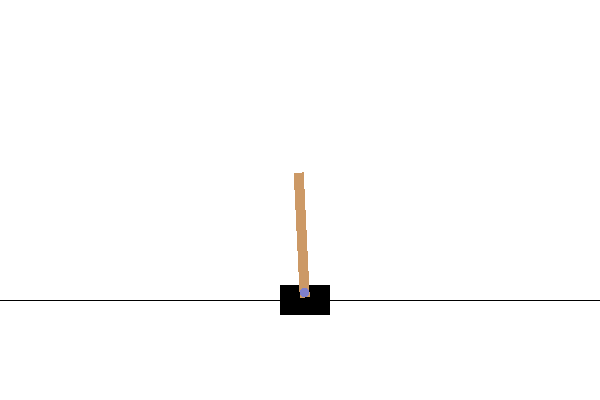

In [11]:
print ('global_step:')
print (global_step)
run_episodes_and_create_video(agent.policy, eval_env, eval_py_env)

## Setup Checkpointer and PolicySaver

Now we are ready to use Checkpointer and PolicySaver.

### Checkpointer


In [12]:
checkpoint_dir = os.path.join(tempdir, 'checkpoint')
train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=global_step
)

### Policy Saver

In [13]:
policy_dir = os.path.join(tempdir, 'policy')
tf_policy_saver = policy_saver.PolicySaver(agent.policy)

### Train one iteration

In [14]:
#@test {"skip": true}
print('Training one iteration....')
train_one_iteration()

Training one iteration....


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))


iteration: 1 loss: 0.9551953077316284


### Save to checkpoint

In [15]:
train_checkpointer.save(global_step)

### Restore checkpoint

For this to work, the whole set of objects should be recreated the same way as when the checkpoint was created.

In [16]:
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Also save policy and export to a location

In [17]:
tf_policy_saver.save(policy_dir)

INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


The policy can be loaded without having any knowledge of what agent or network was used to create it. This makes deployment of the policy much easier.

Load the saved policy and check how it performs


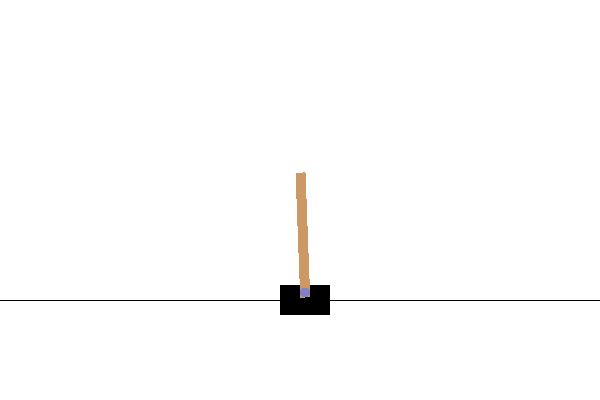

In [18]:
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)

## Export and import
The rest of the colab will help you export / import checkpointer and policy directories such that you can continue training at a later point and deploy the model without having to train again.

Now you can go back to 'Train one iteration' and train a few more times such that you can understand the difference later on. Once you start to see slightly better results, continue below.

In [19]:
#@title Create zip file and upload zip file (double-click to see the code)
def create_zip_file(dirname, base_filename):
  return shutil.make_archive(base_filename, 'zip', dirname)

def upload_and_unzip_file_to(dirname):
  if files is None:
    return
  uploaded = files.upload()
  for fn in uploaded.keys():
    print('User uploaded file "{name}" with length {length} bytes'.format(
        name=fn, length=len(uploaded[fn])))
    shutil.rmtree(dirname)
    zip_files = zipfile.ZipFile(io.BytesIO(uploaded[fn]), 'r')
    zip_files.extractall(dirname)
    zip_files.close()

Create a zipped file from the checkpoint directory.

In [20]:
train_checkpointer.save(global_step)
checkpoint_zip_filename = create_zip_file(checkpoint_dir, os.path.join(tempdir, 'exported_cp'))

Download the zip file.

In [21]:
#@test {"skip": true}
if files is not None:
  files.download(checkpoint_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

After training for some time (10-15 times), download the checkpoint zip file,
and go to "Runtime > Restart and run all" to reset the training,
and come back to this cell. Now you can upload the downloaded zip file,
and continue the training.

In [22]:
#@test {"skip": true}
upload_and_unzip_file_to(checkpoint_dir)
train_checkpointer.initialize_or_restore()
global_step = tf.compat.v1.train.get_global_step()

Once you have uploaded checkpoint directory, go back to 'Train one iteration' to continue training or go back to 'Generate a video' to check the performance of the loaded poliicy.

Alternatively, you can save the policy (model) and restore it.
Unlike checkpointer, you cannot continue with the training, but you can still deploy the model. Note that the downloaded file is much smaller than that of the checkpointer.

In [23]:
tf_policy_saver.save(policy_dir)
policy_zip_filename = create_zip_file(policy_dir, os.path.join(tempdir, 'exported_policy'))

INFO:tensorflow:Assets written to: /tmp/policy/assets


INFO:tensorflow:Assets written to: /tmp/policy/assets


In [24]:
#@test {"skip": true}
if files is not None:
  files.download(policy_zip_filename) # try again if this fails: https://github.com/googlecolab/colabtools/issues/469

Upload the downloaded policy directory (exported_policy.zip) and check how the saved policy performs.


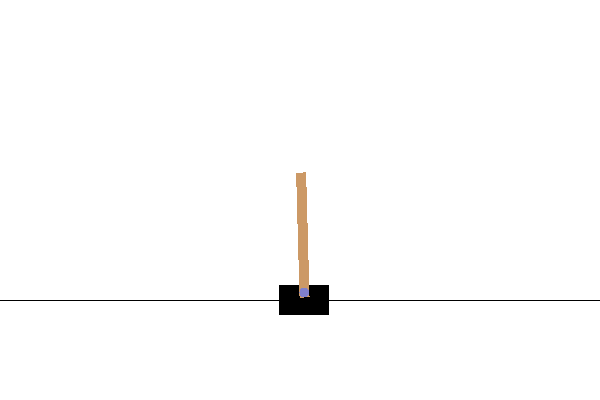

In [25]:
#@test {"skip": true}
upload_and_unzip_file_to(policy_dir)
saved_policy = tf.compat.v2.saved_model.load(policy_dir)
run_episodes_and_create_video(saved_policy, eval_env, eval_py_env)


## SavedModelPyTFEagerPolicy

If you don't want to use TF policy, then you can also use the saved_model directly with the Python env through the use of `py_tf_eager_policy.SavedModelPyTFEagerPolicy`.

Note that this only works when eager mode is enabled.


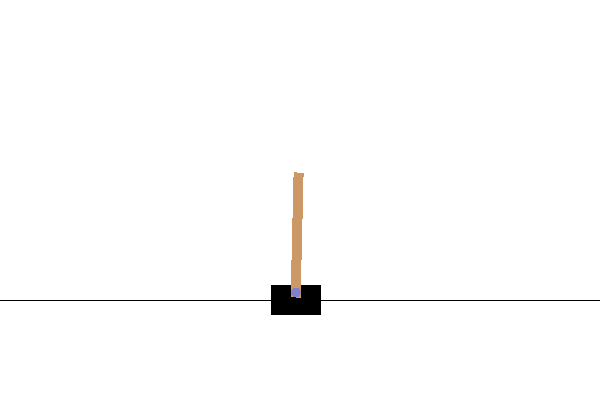

In [26]:
eager_py_policy = py_tf_eager_policy.SavedModelPyTFEagerPolicy(
    policy_dir, eval_py_env.time_step_spec(), eval_py_env.action_spec())

# Note that we're passing eval_py_env not eval_env.
run_episodes_and_create_video(eager_py_policy, eval_py_env, eval_py_env)